In [1]:
import pandas as pd 
import numpy as np 
import os 
import glob
from utils import * 
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
def balanced_accuracy(df:pd.DataFrame):
    '''Compute the balanced accuracy.'''
    return balanced_accuracy_score(df.label, df.model_label)

In [3]:
test_results_df = pd.read_csv('../data/results/dataset_test_predict.csv', index_col=0).assign(dataset='test')
test_results_df = test_results_df.merge(pd.read_csv('../data/dataset/dataset_test.csv', index_col=0), left_index=True, right_index=True, how='left')

train_results_df = pd.read_csv('../data/results/dataset_train_predict.csv', index_col=0).assign(dataset='train')
train_results_df = train_results_df.merge(pd.read_csv('../data/dataset/dataset_train.csv', index_col=0), left_index=True, right_index=True, how='left')

results_df = pd.concat([train_results_df, test_results_df])
results_df['length'] = results_df.seq.apply(len)

In [4]:
def si_table_1(results_df:pd.DataFrame):
    '''Results of each model on the combined training and testing dataset, with labels assigned using the default threshold
    of 0.5. The v2 model has slightly higher accuracy than the v3 model, so we opted to use v2 for all subsequent analysis.'''

    model_names = [os.path.basename(path).replace('.pkl', '') for path in glob.glob('../models/*pkl')]

    table_df = list()
    for model_name in model_names:
        row = dict()
        row['model_name'] = model_name

        tn, fp, fn, tp = confusion_matrix(results_df['label'], results_df[f'{model_name}_label']).ravel()
        row['true_positive'] = tp
        row['true_negative'] = tn
        row['false_positive'] = fp
        row['false_negative'] = fn
        row['accuracy'] = np.round(balanced_accuracy_score(results_df.label, results_df[f'{model_name}_label']), 4)
        table_df.append(row)

    table_df = pd.DataFrame(table_df).set_index('model_name')
    table_df = table_df.sort_values('false_positive')

    return table_df

si_table_1(results_df)


,true_positive,true_negative,false_positive,false_negative,accuracy
model_name,,,,,
model_v1,258325,17221,3,1041,0.9979
model_v2,258687,17216,8,679,0.9985
model_v3,258686,17214,10,680,0.9984


In [5]:
model_name = 'model_v2' # Select model_v2 as the model to use for all subsequent analysis.

train_results_df = train_results_df.rename(columns={col:col.replace(model_name, 'model') for col in train_results_df.columns})
test_results_df = test_results_df.rename(columns={col:col.replace(model_name, 'model') for col in test_results_df.columns})
results_df = results_df.rename(columns={col:col.replace(model_name, 'model') for col in results_df.columns})

In [6]:
def recall(df:pd.DataFrame, label=0, threshold:float=None) -> float:
    '''Computes the precision of the model's predictions. Recall summarizes how well the positive class was predicted and is the same calculation as sensitivity.'''
    model_labels = np.where(df[f'model_output_{label}'] > threshold, label, int(not label))
    n = ((model_labels == label) & (df.label == label)).sum()
    N = (df.label == label).sum() # Total number of relevant instances (i.e. members of the class)
    return n / N

def precision(df:pd.DataFrame, label=0, threshold:float=None) -> float:
    '''Computes the precision of the model's predictions. Precision summarizes the fraction of examples assigned the positive class that belong to the positive class.'''
    model_labels = np.where(df[f'model_output_{label}'] > threshold, label, int(not label))
    n = ((model_labels == label) & (df.label == label)).sum()
    N = (model_labels == label).sum() # Total number of retrieved instances (i.e. predicted members of the class)
    return n / N

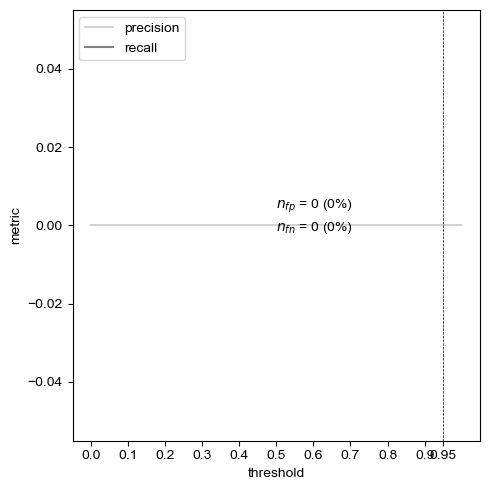

In [17]:

def figure_1(results_df, threshold:float=0.95, label:int=0):
    '''The variation of precision and recall with respect to the selected threshold. Precision and recall are computed
    with respect to the {label} class. We opted for a threshold of 0.95 in order to minimize the false negative rate, 
    i.e. the proportion of real sequences incorrectly-classified as spurious.'''

    min_threshold = results_df[f'model_output_{label}'].min() + 1e-3
    max_threshold = results_df[f'model_output_{label}'].max() - 1e-3

    thresholds = [min_threshold] + list(np.linspace(0.1, 0.99, 20)) + [max_threshold]
    ax_df = pd.DataFrame(index=np.arange(len(thresholds)))
    ax_df['threshold'] = thresholds
    ax_df['precision'] = [precision(results_df, label=label, threshold=threshold) for threshold in thresholds]
    ax_df['recall'] = [recall(results_df, label=label, threshold=threshold) for threshold in thresholds]

    fig, ax = plt.subplots(figsize=(5, 5))

    sns.lineplot(data=ax_df, ax=ax, x='threshold', y='precision', label='precision', color='lightgray')
    sns.lineplot(data=ax_df, ax=ax, x='threshold', y='recall', label='recall', color='gray')
    ax.axvline(threshold, color='black', linewidth=0.5, linestyle='--')

    results_df['model_label'] = np.where(results_df[f'model_output_{label}'] > threshold, label, int(not label))
    n_fn = ((results_df.model_label == 0) & (results_df.label == 1)).sum()
    n_fp = ((results_df.model_label == 1) & (results_df.label == 0)).sum()
    ax.text(0.5, 0.5, get_text('fp', n_fp, (results_df.label == 0).sum()), transform=ax.transAxes) # Percentage indicates the false positive rate.
    ax.text(0.5, 0.45, get_text('fn', n_fn, (results_df.label == 1).sum()), transform=ax.transAxes) # Percentage indicates the false negative rate.

    ax.set_ylabel('')
    x_ticks = sorted(list(np.arange(10) / 10) + [threshold])
    ax.set_xticks(x_ticks, labels=x_ticks)
    ax.set_ylabel('metric')

    fig.tight_layout()
    plt.show()

figure_1(results_df, threshold=0.95, label=0)
# figure_1(results_df, threshold=0.8, label=1)

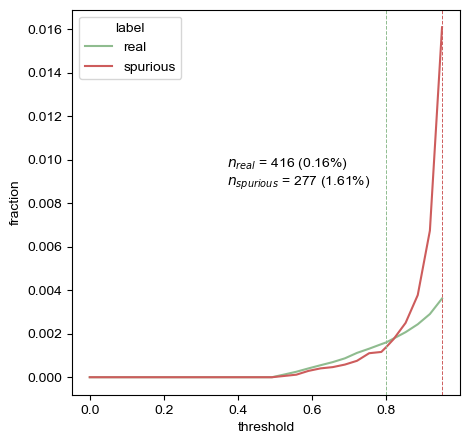

In [8]:
# If we apply the threshold to both real and spurious classification, how many will be "uncertain"?

def figure(results_df:pd.DataFrame, real_threshold:float=0.8, spurious_threshold:float=0.95):
    fig, ax = plt.subplots(figsize=(5, 5))

    thresholds = list(np.linspace(0, 0.95, 30)) + [real_threshold, spurious_threshold]

    results_df = results_df.copy()
    if results_df.label.dtype == int:
        results_df['label'] = np.where(results_df.label == 0, 'spurious', 'real')

    n, n_real, n_spurious = len(results_df), (results_df.label == 'real').sum(), (results_df.label == 'spurious').sum()

    figure_df = list()
    for threshold in thresholds:
        results_df = apply_thresholds(results_df, real_threshold=threshold, spurious_threshold=threshold)

        # figure_df.append({'threshold':threshold, 'label':'total', 'count':results_df.uncertain.sum(), 'total':n})
        figure_df.append({'threshold':threshold, 'label':'real', 'count':(results_df.uncertain & (results_df.label == 'real')).sum(), 'total':n_real})
        figure_df.append({'threshold':threshold, 'label':'spurious', 'count':(results_df.uncertain & (results_df.label == 'spurious')).sum(), 'total':n_spurious})
    
    figure_df = pd.DataFrame(figure_df)
    figure_df['fraction'] = figure_df['count'] / figure_df['total']

    palette = {'real':'darkseagreen', 'spurious':'indianred', 'total':'lightgray'}
    sns.lineplot(figure_df, x='threshold', y='fraction', hue='label', palette=palette)

    text = ''
    for label, df in figure_df.groupby('label'):
        threshold = real_threshold if (label == 'real') else spurious_threshold
        text += get_text(label, df[df.threshold == threshold]['count'].iloc[0], df[df.threshold == threshold]['total'].iloc[0])
    ax.text(0.4, 0.5, text, transform=ax.transAxes)
    ax.axvline(real_threshold, ls='--', lw=0.7, color='darkseagreen')
    ax.axvline(spurious_threshold, ls='--', lw=0.7, color='indianred')
    plt.show()

figure(results_df)

In [9]:
thresholds = (0.8, 0.95) # Apply the selected threshold to the sequences. 

if results_df.label.dtype == int:
    results_df['label'] = np.where(results_df.label == 0, 'spurious', 'real')

results_df = apply_thresholds(results_df, *thresholds)

fp_results_df = results_df[(results_df.model_label == 'real') & (results_df.label == 'spurious')].copy()
fn_results_df = results_df[(results_df.model_label == 'spurious') & (results_df.label == 'real')].copy()
tp_results_df = results_df[(results_df.model_label == 'real') & (results_df.label == 'real')].copy()
tn_results_df = results_df[(results_df.model_label == 'spurious') & (results_df.label == 'spurious')].copy()

n_real, n_spurious = (results_df.label == 'real').sum(), (results_df.label == 'spurious').sum()
n_real_test, n_spurious_test = ((results_df.label == 'real') & (results_df.dataset == 'test')).sum(), ((results_df.label == 'spurious') & (results_df.dataset == 'test')).sum()
n_real_train, n_spurious_train = ((results_df.label == 'real') & (results_df.dataset == 'train')).sum(), ((results_df.label == 'spurious') & (results_df.dataset == 'train')).sum()

print('Num false positives:', len(fp_results_df), f'({get_percent(len(fp_results_df), n_spurious)})')
print('Num. false positives in testing dataset:', (fp_results_df.dataset == 'test').sum(), f'({get_percent((fp_results_df.dataset == 'test').sum(), n_spurious_test)})')
print('Num. false positives in training dataset:', (fp_results_df.dataset == 'train').sum(), f'({get_percent((fp_results_df.dataset == 'train').sum(), n_spurious_train)})', end='\n\n')

print('Num. false negatives:', len(fn_results_df), f'({get_percent(len(fn_results_df), n_real)})')
print('Num. false negatives in testing dataset:', (fn_results_df.dataset == 'test').sum(), f'({get_percent((fn_results_df.dataset == 'test').sum(), n_real_test)})')
print('Num. false negatives in training dataset:', (fn_results_df.dataset == 'train').sum(), f'({get_percent((fn_results_df.dataset == 'train').sum(), n_real_train)})')


Num false positives: 3 (0.02%)
Num. false positives in testing dataset: 1 (0.03%)
Num. false positives in training dataset: 2 (0.01%)

Num. false negatives: 300 (0.12%)
Num. false negatives in testing dataset: 13 (0.03%)
Num. false negatives in training dataset: 287 (0.14%)


In [ ]:
def table(results_df:pd.DataFrame, exclude_uncertain:bool=False):
    '''Precision, recall, and balanced accuracy of the model on the training and testing datasets. Sequences classified as "uncertain"
    are considered to be mislabeled unless explicitly excluded.'''

    def recall(df:pd.DataFrame, label='spurious') -> float:
        '''Computes the precision of the model's predictions. Recall summarizes how well the positive class was predicted and is the same calculation as sensitivity.'''
        n = ((df.model_label == label) & (df.label == label)).sum()
        N = (df.label == label).sum() # Total number of relevant instances (i.e. members of the class)
        return n / N

    def precision(df:pd.DataFrame, label='spurious') -> float:
        '''Computes the precision of the model's predictions. Precision summarizes the fraction of examples assigned the positive class that belong to the positive class.'''
        n = ((df.model_label == label) & (df.label == label)).sum()
        N = (df.model_label == label).sum() # Total number of retrieved instances (i.e. predicted members of the class)
        return n / N

    if exclude_uncertain:
        print(f'table: Excluding {results_df.uncertain.sum()} uncertain predictions.')
        results_df = results_df[results_df.model_label != 'uncertain'].copy()
    results_df

    masks = dict()
    masks['all'] = [True] * len(results_df)
    masks['train'] = (results_df.dataset == 'train')
    masks['test'] = (results_df.dataset == 'test')

    table_df = list()
    for dataset, mask in masks.items():
        table_df.append({'metric':'balanced accuracy', 'value':balanced_accuracy(results_df[mask]), 'dataset':dataset})
        table_df.append({'metric':'precision', 'value':precision(results_df[mask]), 'dataset':dataset})
        table_df.append({'metric':'recall', 'value':recall(results_df[mask]), 'dataset':dataset})
    table_df = pd.DataFrame(table_df)
    table_df = table_df.pivot(index='metric', columns='dataset', values='value')
    return table_df

table(results_df)

dataset,all,test,train
metric,,,
balanced accuracy,0.990112,0.989149,0.990320
precision,0.982603,0.995955,0.979544
recall,0.983744,0.979498,0.984738


In [16]:
# Because there are so few false positive sequences in the training data, we can look at them manually here.
fields = ['species', 'antifam_id', 'antifam_description', 'length']
for row in fp_results_df.itertuples():
    print(row.Index)
    for field in fields:
        print(f'{field}:', getattr(row, field))
    print(row.seq)
    print()

A0AAQ1SN28
species: Leptospira interrogans
antifam_id: ANF00056
antifam_description: Translation of DNA repeat
length: 42
METTTNLTTLDLLESSQIDKYNLICRNYCILKISKELSRKIL

A0A2X3JQU9
species: Escherichia coli
antifam_id: ANF00071
antifam_description: Translation of intergenic region
length: 36
MFIAWYWIVLIALVVVGYFLHLNVIVGRFARTGRTA

A0A1R3T7N6
species: Proteiniphilum saccharofermentans
antifam_id: ANF00014
antifam_description: tRNA translation
length: 59
MFNFKTKKKASAIKTNAFNSNYLAFAVWTGLEPATPCVTGRYSNQLNYHTIFGYYVWTC



In [ ]:
# A0AAQ1SN28 is an identical match with SOR60967.1 (locus LMANV2_240019), which is found in a genome with a RefSeq reference annotation
# (GCF_900236655.1). Although it is not annotated in the PGAP annotation, there is also no annotated DNA repeat in the region. Sequence seems
# to be highly-conserved. AlphaFold structure is a short alpha helix. HMM for ANF00056 is here: https://github.com/ebi-pf-team/antifam/blob/master/ENTRIES/ANF00056.seed

# A0A2X3JQU9 is found in an E. coli genome, immediately downstream of ygiE_1 (a zinc transporter). It aligns to E. coli protein yqiD. According to
# EcoCyc, this protein is expressed at during exponential growth and stationary phase in rich growth medium. AlphaFold structure is a short,
# high-confidence alpha helix. HMM for ANF00071 is here: https://github.com/ebi-pf-team/antifam/blob/master/ENTRIES/ANF00071.seed

# A0A1R3T7N6 has multiple strong hits to hypothetical proteins in different species, including an exact match SCD19594.1 (locus PSM36_0767). 
# Sequence has no secondary structure.Genome in which the exact match was found has a PGAP-annotated reference assembly (GCF_900095135.1).
# It is not annotated in the RefSeq genome; a tRNA-Arg is predicted at the same locus.
